In [78]:
import pandas as pd 
import numpy as np 
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import shap
from joblib import dump, load

### 3.1 Repetimos la partición de los datos

In [79]:
df_02 = pd.read_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\df_02.csv')
X_train_final = pd.read_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\X_train_final.csv')
X_test_final = pd.read_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\X_test_final.csv')

In [80]:
# Separamos variables del objetivo (churn)
X = df_02.drop(columns=['Churn'])
y = df_02['Churn']

# Partición train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### Comentario: Sin haber tomado en cuenta el desbalance de las clases, hicimos un primer entrenamiento.

In [81]:
#Entrenamiento con Regresión Logística
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_final, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [82]:
#Predicciones en test
y_pred = clf.predict(X_test_final)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8134715025906736

Confusion Matrix:
 [[151   2]
 [ 34   6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.89       153
           1       0.75      0.15      0.25        40

    accuracy                           0.81       193
   macro avg       0.78      0.57      0.57       193
weighted avg       0.80      0.81      0.76       193



#### **Comentario:** El modelo tiene buen nivel de Accuracy pero el nivel de recall en la condición de 'Churn' que nos interesa (activo = 1) es extremadamente bajo. Queremos evitar a toda costa los falsos negativos para poder detectar clientes que quieren desuscribirse o tienen intenciones y poder mantener el servicio.

In [83]:
# Crear DataFrame de coeficientes
coef_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': clf.coef_[0],
    'Odds_Ratio': np.exp(clf.coef_[0])
}).sort_values(by='Odds_Ratio', ascending=False)

print(coef_df)

                           Feature  Coefficient  Odds_Ratio
12      PaymentMethod_Mailed check     0.663604    1.941779
14              ContentType_Movies     0.362136    1.436394
1                   MonthlyCharges     0.357241    1.429380
15            ContentType_TV Shows     0.346233    1.413732
6           SupportTicketsPerMonth     0.214064    1.238702
17         DeviceRegistered_Mobile     0.170843    1.186305
7                    WatchlistSize     0.125054    1.133210
25             ParentalControl_Yes     0.099316    1.104416
13            PaperlessBilling_Yes     0.066025    1.068253
11  PaymentMethod_Electronic check     0.063799    1.065879
20          GenrePreference_Comedy     0.011772    1.011842
16           MultiDeviceAccess_Yes     0.001478    1.001479
21           GenrePreference_Drama    -0.001873    0.998129
18             DeviceRegistered_TV    -0.009510    0.990535
24                     Gender_Male    -0.068201    0.934072
23          GenrePreference_Sci-Fi    -0

In [84]:
#Revisar los 10 features con mayor Odds Ratio
coef_df.head(10)

,Feature,Coefficient,Odds_Ratio
12,PaymentMethod_Mailed check,0.663604,1.941779
14,ContentType_Movies,0.362136,1.436394
1,MonthlyCharges,0.357241,1.429380
15,ContentType_TV Shows,0.346233,1.413732
6,SupportTicketsPerMonth,0.214064,1.238702
17,DeviceRegistered_Mobile,0.170843,1.186305
7,WatchlistSize,0.125054,1.133210
25,ParentalControl_Yes,0.099316,1.104416
13,PaperlessBilling_Yes,0.066025,1.068253
11,PaymentMethod_Electronic check,0.063799,1.065879


### 3.2 **SMOTE** - BALANCEO DE CLASES

In [85]:
# Definir SMOTE
smote = SMOTE(sampling_strategy=1.0, random_state=42)  # 1.0 = balance perfecto

# Aplicar SMOTE solo en train
X_train_res, y_train_res = smote.fit_resample(X_train_final, y_train)

# Revisamos el nuevo balance
print("Distribución de clases después de SMOTE:")
print(y_train_res.value_counts())

Distribución de clases después de SMOTE:
Churn
1    641
0    641
Name: count, dtype: int64


In [86]:
# Modelado con datos balanceados
clf_smote = LogisticRegression(max_iter=1000, random_state=42)
clf_smote.fit(X_train_res, y_train_res)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [87]:
#Preddicción sin SMOTE (ojo!)
y_pred = clf_smote.predict(X_test_final)

print("Accuracy test:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Active','Churn']))

Accuracy test: 0.7098445595854922

Confusion Matrix:
 [[106  47]
 [  9  31]]

Classification Report:
               precision    recall  f1-score   support

      Active       0.92      0.69      0.79       153
       Churn       0.40      0.78      0.53        40

    accuracy                           0.71       193
   macro avg       0.66      0.73      0.66       193
weighted avg       0.81      0.71      0.74       193



### 3.3 Búsqueda de Hiperparámetros - GridSearch

In [88]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # L1 requiere solver='liblinear' o 'saga'
    'solver': ['lbfgs', 'saga']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                    param_grid, scoring='recall', cv=5) #Mejora en la detección de falsos negativos
grid.fit(X_train_res, y_train_res) #sobre balance de clases (SMOTE)

print("Mejor hiperparámetro:", grid.best_params_)
print("Mejor recall CV:", grid.best_score_)


Mejor hiperparámetro: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Mejor recall CV: 0.6973958333333333


### 3.4 Cross-Validation 

In [89]:
#Selección del modelo con los mejores hiperparámetros
clf_cv = LogisticRegression(
    C= 10, 
    penalty='l2', 
    solver='lbfgs', 
    max_iter=1000, 
    random_state=42
)

In [90]:
# CV con 5 folds, evaluando recall para churners
cv_recall = cross_val_score(clf_cv, X_train_res, y_train_res, cv=5, scoring='recall')

print("Recall promedio CV:", cv_recall.mean())
print("Recall CV por fold:", cv_recall)

Recall promedio CV: 0.6973958333333333
Recall CV por fold: [0.66666667 0.7265625  0.7109375  0.7421875  0.640625  ]


### **Modelado - Entramiento** y test con mejores hiperparámetros con el target balanceado

In [91]:
# Usando los mejores hiperparámetros encontrados en GridSearch
clf_final = LogisticRegression(
    C=10,       
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

# Entrenamos en todo el train balanceado (SMOTE)
clf_final.fit(X_train_res, y_train_res)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [92]:
# Probabilidades de churn
y_prob = clf_final.predict_proba(X_test_final)[:,1]

# Predicciones con umbral 0.4 (justificaré más abajo)
y_pred = (y_prob > 0.4).astype(int)

In [93]:
print("Accuracy test:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Active','Churn']))

Accuracy test: 0.6528497409326425

Confusion Matrix:
 [[91 62]
 [ 5 35]]

Classification Report:
               precision    recall  f1-score   support

      Active       0.95      0.59      0.73       153
       Churn       0.36      0.88      0.51        40

    accuracy                           0.65       193
   macro avg       0.65      0.73      0.62       193
weighted avg       0.83      0.65      0.69       193



In [94]:
# Guardar el modelo entrenado
dump(clf_final, r"C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\models\clf_final.joblib")

#Guardar el dataset de train balanceado
X_train_res = X_train_res.to_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\X_train_res.csv', index=False)


### 3.5 Visualizaciones

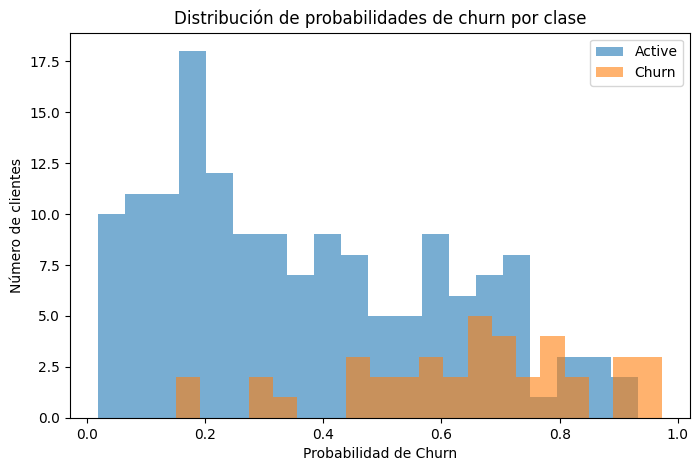

In [95]:
# Probabilidades de churn
y_prob = clf_final.predict_proba(X_test_final)[:,1]

plt.figure(figsize=(8,5))
plt.hist(y_prob[y_test==0], bins=20, alpha=0.6, label='Active')
plt.hist(y_prob[y_test==1], bins=20, alpha=0.6, label='Churn')
plt.xlabel("Probabilidad de Churn")
plt.ylabel("Número de clientes")
plt.title("Distribución de probabilidades de churn por clase")
plt.legend()
plt.show()

In [96]:
plt.savefig(r"C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\reports\figures\prob_churn.png", dpi=300)

<Figure size 640x480 with 0 Axes>

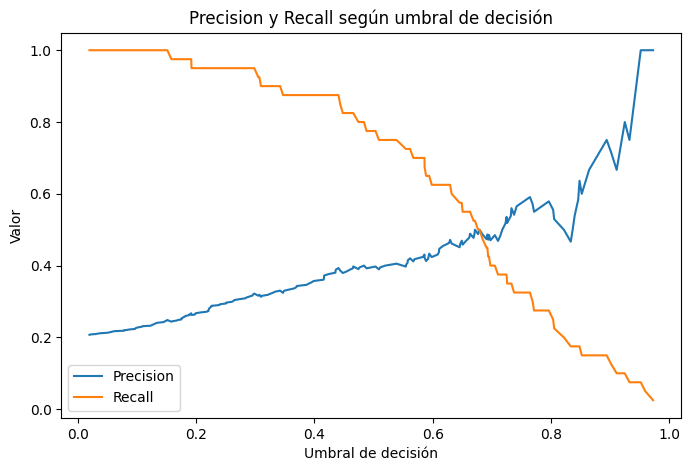

In [97]:
#Visualización de Precision-Recall vs Umbral de decisión
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Umbral de decisión")
plt.ylabel("Valor")
plt.title("Precision y Recall según umbral de decisión")
plt.legend()
plt.show()

In [98]:
plt.savefig(r"C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\reports\figures\dec_umbral.png", dpi=300)

<Figure size 640x480 with 0 Axes>

In [99]:
#Guardamos el X_test_final procesado para SHAP
X_test_final = X_test_final.to_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\X_test_final.csv', index=False)


In [100]:
coef = pd.Series(clf_final.coef_[0], index=X_train_final.columns)
coef.sort_values(ascending=False)

PaymentMethod_Mailed check        1.028493
MonthlyCharges                    0.443373
ContentType_Movies                0.353175
ContentType_TV Shows              0.261450
SupportTicketsPerMonth            0.248411
WatchlistSize                     0.171807
ParentalControl_Yes               0.112667
PaymentMethod_Electronic check    0.111885
Gender_Male                       0.062748
DeviceRegistered_Mobile           0.059842
PaperlessBilling_Yes              0.018484
MultiDeviceAccess_Yes            -0.078793
SubscriptionType_Standard        -0.162586
TotalCharges                     -0.211659
GenrePreference_Comedy           -0.218691
PaymentMethod_Credit card        -0.222041
GenrePreference_Drama            -0.230847
ContentDownloadsPerMonth         -0.283529
DeviceRegistered_TV              -0.304957
GenrePreference_Sci-Fi           -0.305285
SubscriptionType_Premium         -0.317460
AverageViewingDuration           -0.506135
GenrePreference_Fantasy          -0.567768
ViewingHour

In [101]:
print(y_train.value_counts(normalize=True))

Churn
0    0.832468
1    0.167532
Name: proportion, dtype: float64
